# **TripFare : Predicting Urban Taxi Fare with Machine Learning**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.model_selection import RandomizedSearchCV


import pickle


import warnings
warnings.filterwarnings('ignore')


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

**Loading dataset**

In [2]:
df = pd.read_csv('taxi_fare.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


**Understanding the data**

In [3]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (212345, 18)


In [4]:
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               212345 non-null  int64  
 1   tpep_pickup_datetime   212345 non-null  object 
 2   tpep_dropoff_datetime  212345 non-null  object 
 3   passenger_count        212345 non-null  int64  
 4   pickup_longitude       212345 non-null  float64
 5   pickup_latitude        212345 non-null  float64
 6   RatecodeID             212345 non-null  int64  
 7   store_and_fwd_flag     212345 non-null  object 
 8   dropoff_longitude      212345 non-null  float64
 9   dropoff_latitude       212345 non-null  float64
 10  payment_type           212345 non-null  int64  
 11  fare_amount            212345 non-null  float64
 12  extra                  212345 non-null  float64
 13  mta_tax                212345 non-null  float64
 14  tip_amount         

In [5]:
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


In [6]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64


In [7]:
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,VendorID,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000
mean,1.708338,1.766493,-73.112122,40.279405,1.034152,-73.144178,40.295648,1.324943,12.665588,0.048077,0.497662,1.809357,0.329049,0.299637,15.649355
std,0.454529,1.469647,7.936633,4.370714,0.494699,7.794599,4.293031,0.478255,10.875584,0.148103,0.037436,2.507419,2.028199,0.014094,13.592129
min,1.000000,0.000000,-121.933327,0.000000,1.000000,-121.933327,0.000000,1.000000,-52.000000,-0.500000,-0.500000,-2.700000,0.000000,-0.300000,-52.800000
25%,1.000000,1.000000,-73.990891,40.740292,1.000000,-73.990570,40.740089,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,-73.979469,40.755989,1.000000,-73.978691,40.755508,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.620000
75%,2.000000,2.000000,-73.963295,40.770283,1.000000,-73.964645,40.767475,2.000000,14.500000,0.000000,0.500000,2.360000,0.000000,0.300000,17.160000
max,2.000000,6.000000,0.000000,42.786934,99.000000,0.000000,42.786934,4.000000,819.500000,4.500000,0.500000,218.950000,661.080000,0.300000,832.800000


**Data Cleaning**

In [8]:
print(f"Original data shape: {df.shape}")

df = df[df['fare_amount'] > 0]

# Passenger count should be greater than 0 and less than a reasonable number (e.g., 7)
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

# The latitude and longitude for NYC are within specific ranges.
df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]

print(f"Data shape after initial cleaning: {df.shape}")

Original data shape: (212345, 18)
Data shape after initial cleaning: (209503, 18)


**Feature Engineering**

In [9]:
# 1. Convert to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# 2. trip_distance using Haversine formula
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km * 0.621371

df['trip_distance'] = haversine_distance(df['pickup_longitude'], df['pickup_latitude'],
                                         df['dropoff_longitude'], df['dropoff_latitude'])
print("Successfully created 'trip_distance' column.")


# 3. Trip Duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

df = df[df['trip_distance'] > 0.1]
df = df[(df['trip_duration'] > 1) & (df['trip_duration'] < 120)]

print(f"Data shape after feature engineering and final cleaning: {df.shape}")

# 5. additional datetime features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['is_weekend'] = (df['pickup_day_of_week'] >= 5).astype(int)
df['is_night'] = ((df['pickup_hour'] >= 22) | (df['pickup_hour'] <= 6)).astype(int)

# 6. fare per mile and fare per minute for EDA
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration']

print("\nFeature engineering complete. All new columns added.")
display(df[['trip_distance', 'trip_duration', 'pickup_hour', 'is_weekend', 'is_night']].head())

Successfully created 'trip_distance' column.
Data shape after feature engineering and final cleaning: (206862, 20)

Feature engineering complete. All new columns added.


,trip_distance,trip_duration,pickup_hour,is_weekend,is_night
0,1.949922,7.916667,0,0,1
1,2.673965,11.100000,0,0,1
2,10.314847,31.100000,0,0,1
7,4.939940,16.050000,0,0,1
8,0.520333,4.983333,0,0,1


**Exploratory Data Analysis (EDA)**

Fare vs. Distance

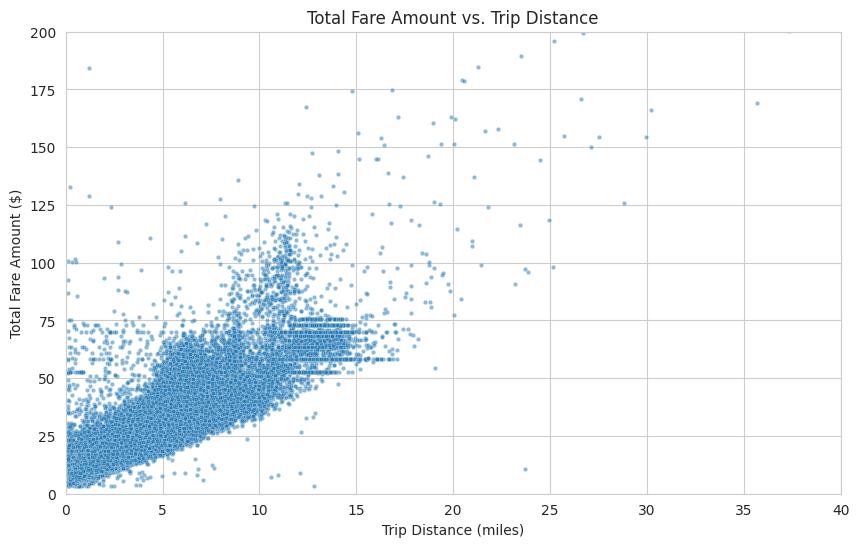

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='total_amount', data=df, alpha=0.5, s=10)
plt.title('Total Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Fare Amount ($)')
plt.xlim(0, 40)
plt.ylim(0, 200)
plt.show()

Fare vs. Passenger Count

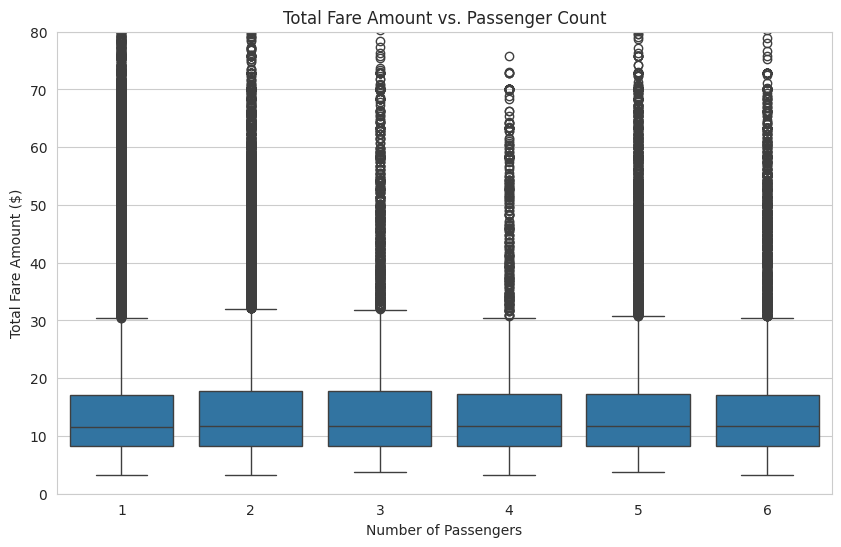

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='total_amount', data=df)
plt.title('Total Fare Amount vs. Passenger Count')
plt.xlabel('Number of Passengers')
plt.ylabel('Total Fare Amount ($)')
plt.ylim(0, 80)
plt.show()

Fare variations across different times of the day

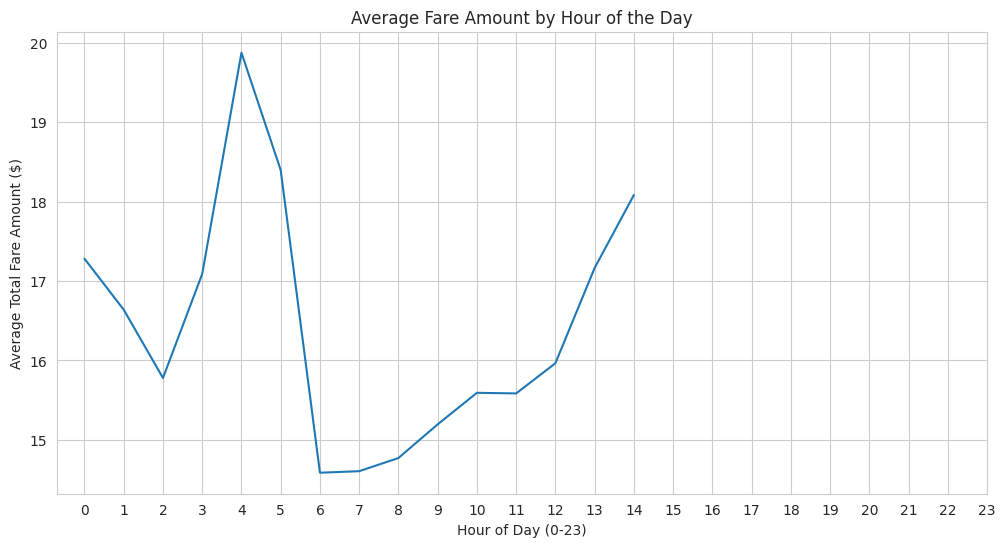

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='total_amount', data=df, estimator='mean', errorbar=None)
plt.title('Average Fare Amount by Hour of the Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Total Fare Amount ($)')
plt.xticks(range(0, 24))
plt.show()

Trip counts by pickup hour (Peak demand)

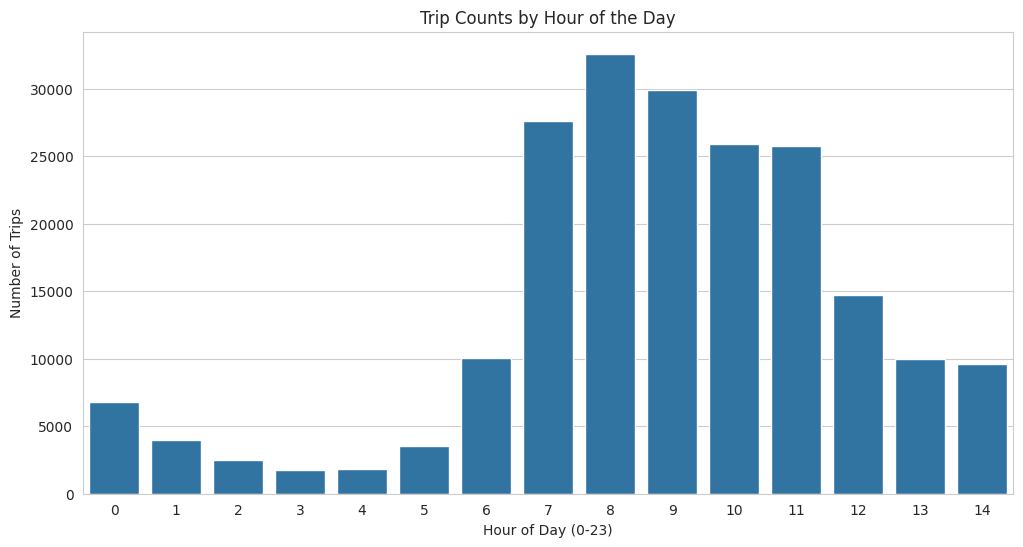

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_hour', data=df)
plt.title('Trip Counts by Hour of the Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Trips')
plt.show()

Investigating the impact of night and weekend trips

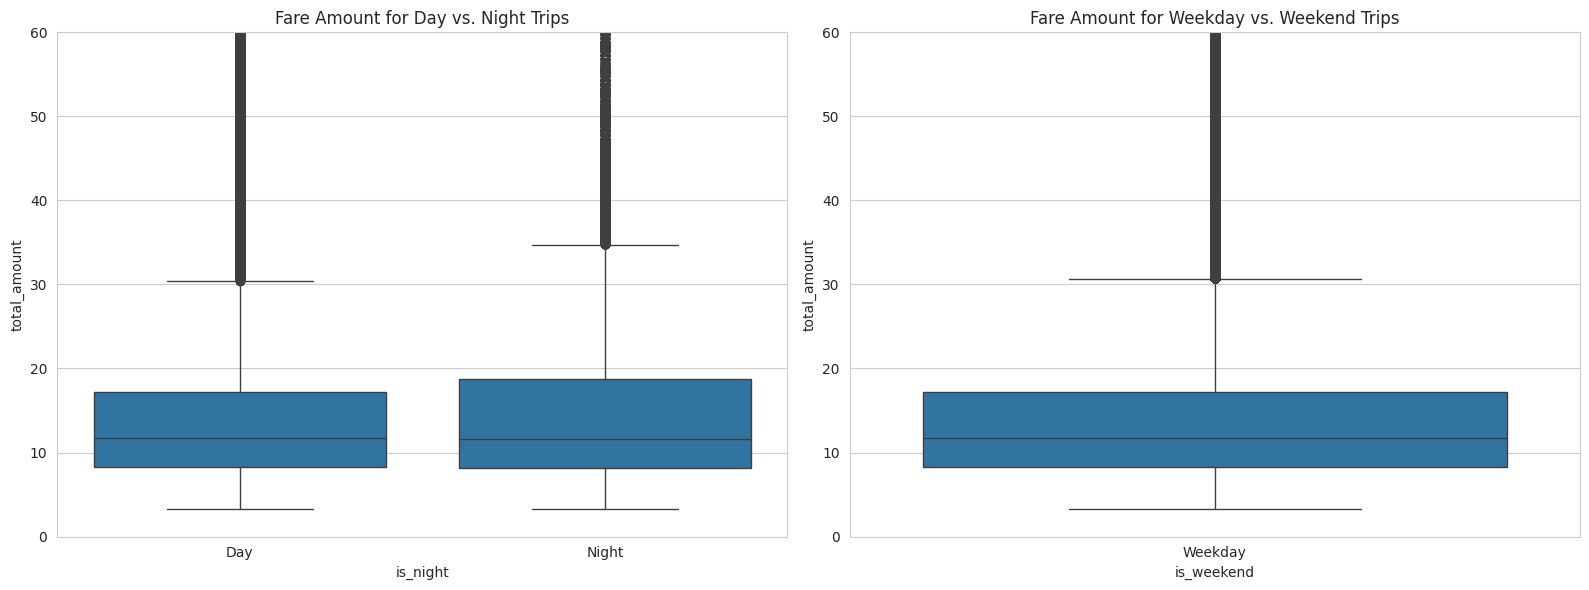

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='is_night', y='total_amount', data=df, ax=axes[0])
axes[0].set_title('Fare Amount for Day vs. Night Trips')
axes[0].set_xticklabels(['Day', 'Night'])
axes[0].set_ylim(0, 60)

sns.boxplot(x='is_weekend', y='total_amount', data=df, ax=axes[1])
axes[1].set_title('Fare Amount for Weekday vs. Weekend Trips')
axes[1].set_xticklabels(['Weekday', 'Weekend'])
axes[1].set_ylim(0, 60)

plt.tight_layout()
plt.show()

Correlation Heatmap

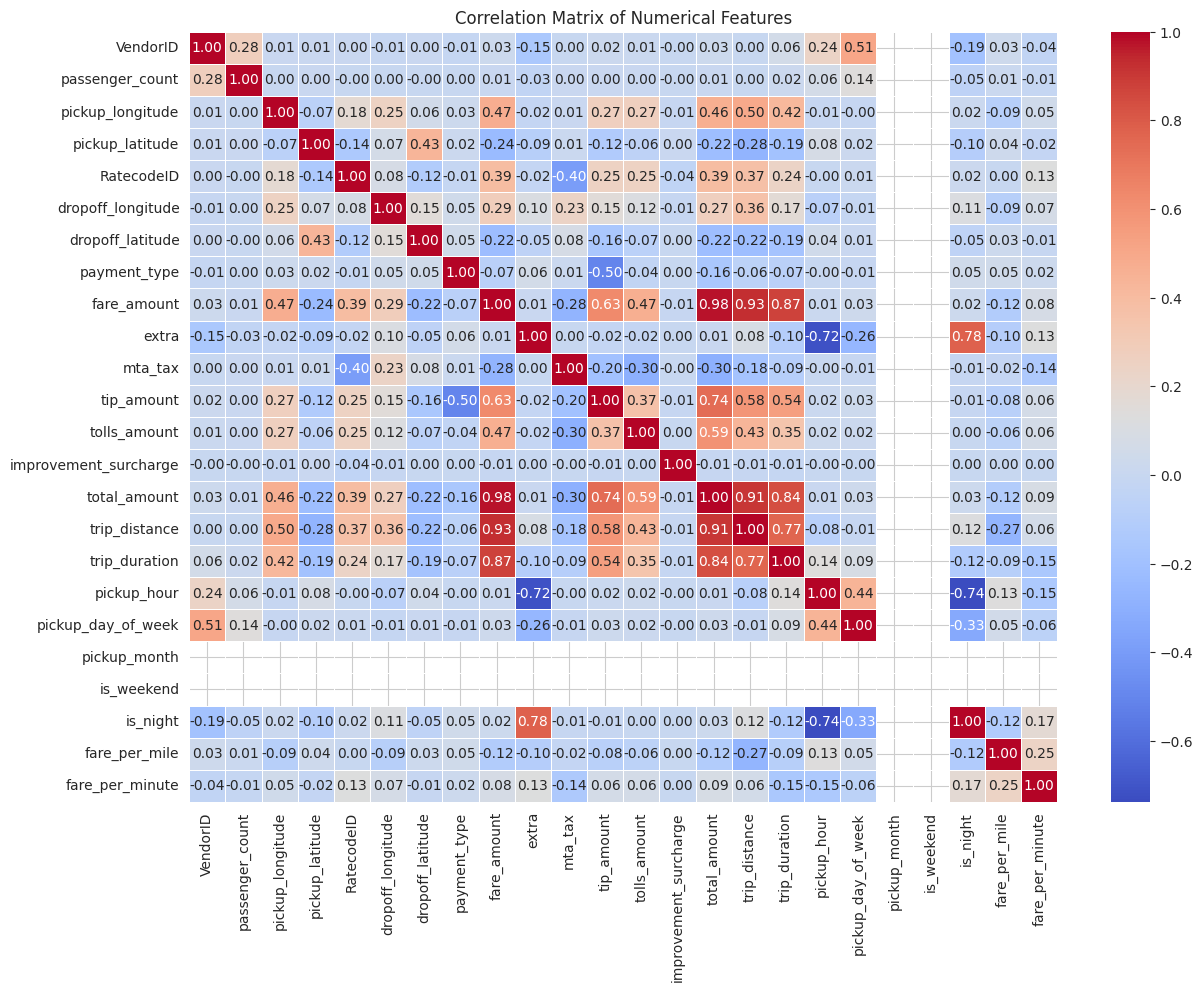

In [15]:
plt.figure(figsize=(14, 10))

numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Data Transformation**

Handle Outliers using IQR

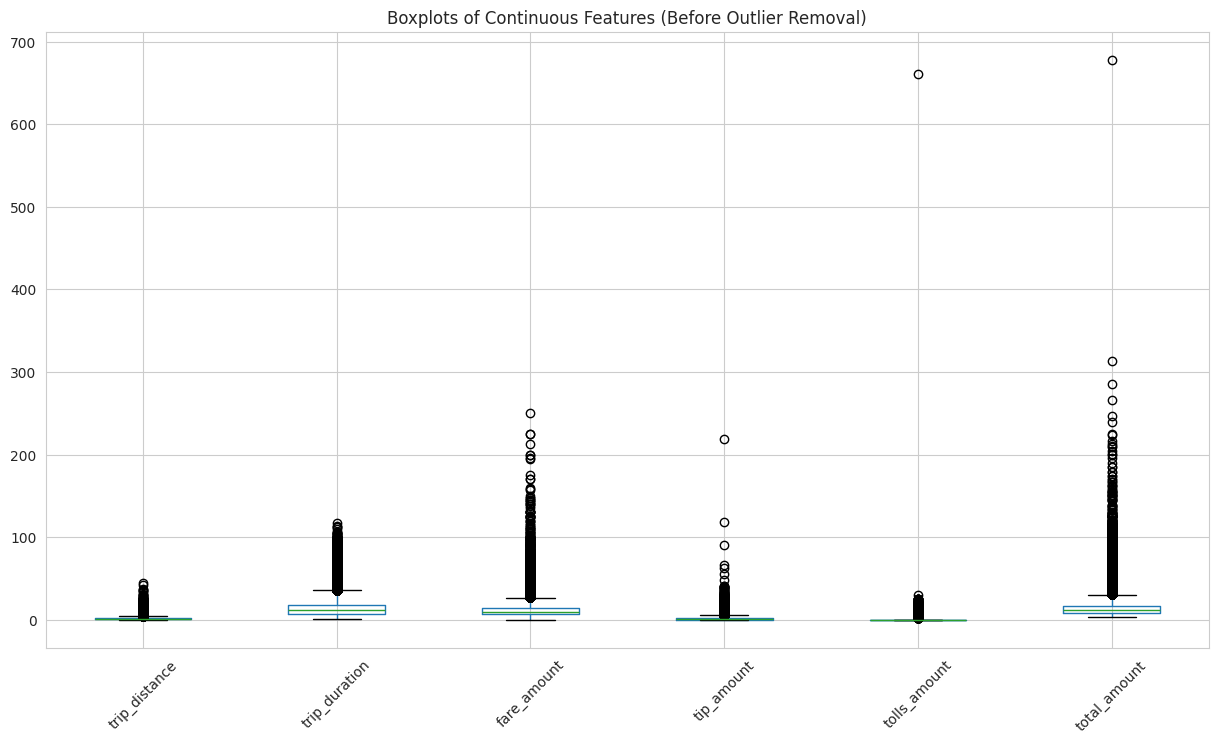

Shape of data before outlier removal: (206862, 27)
Shape of data after outlier removal: (174852, 27)


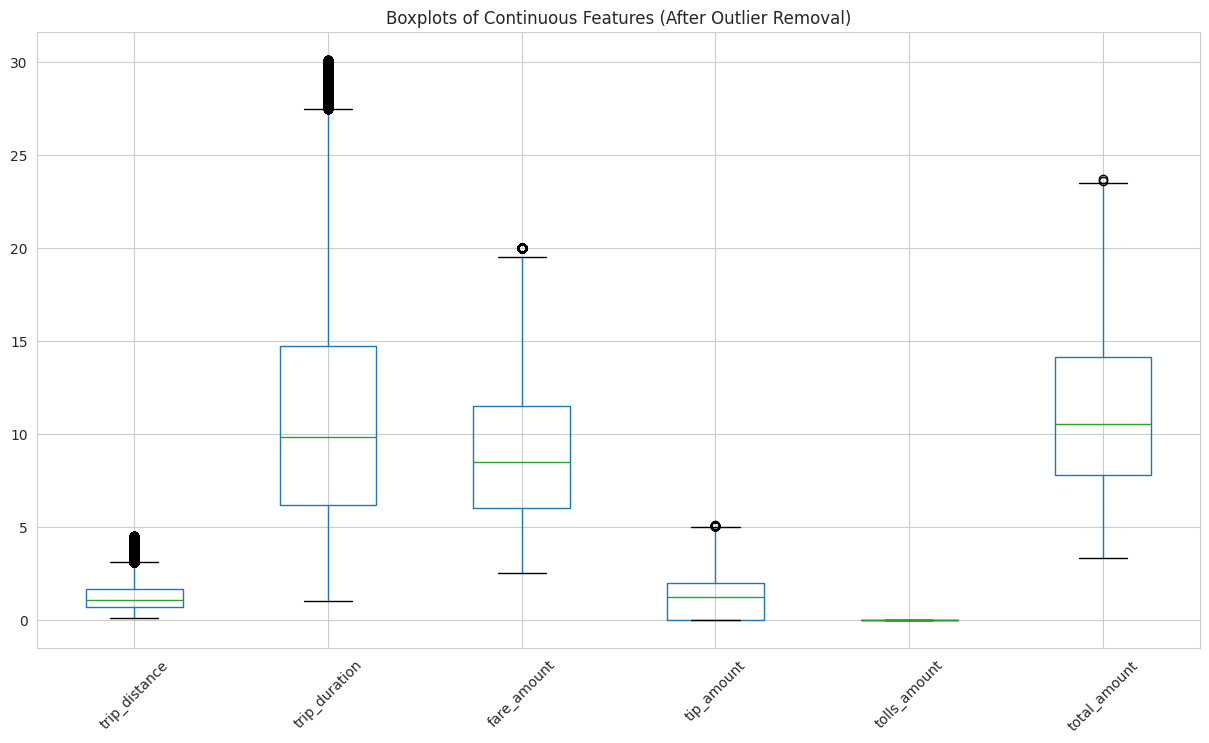

In [16]:
continuous_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']

plt.figure(figsize=(15, 8))
df[continuous_cols].boxplot()
plt.title("Boxplots of Continuous Features (Before Outlier Removal)")
plt.xticks(rotation=45)
plt.show()

# IQR method
print(f"Shape of data before outlier removal: {df.shape}")

for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"Shape of data after outlier removal: {df.shape}")


plt.figure(figsize=(15, 8))
df[continuous_cols].boxplot()
plt.title("Boxplots of Continuous Features (After Outlier Removal)")
plt.xticks(rotation=45)
plt.show()

Fix Skewness in Continuous Variables

Skewness of continuous features:
trip_distance    1.250624
trip_duration    0.719088
fare_amount      0.678290
tip_amount       0.503931
tolls_amount     0.000000
total_amount     0.660090
dtype: float64


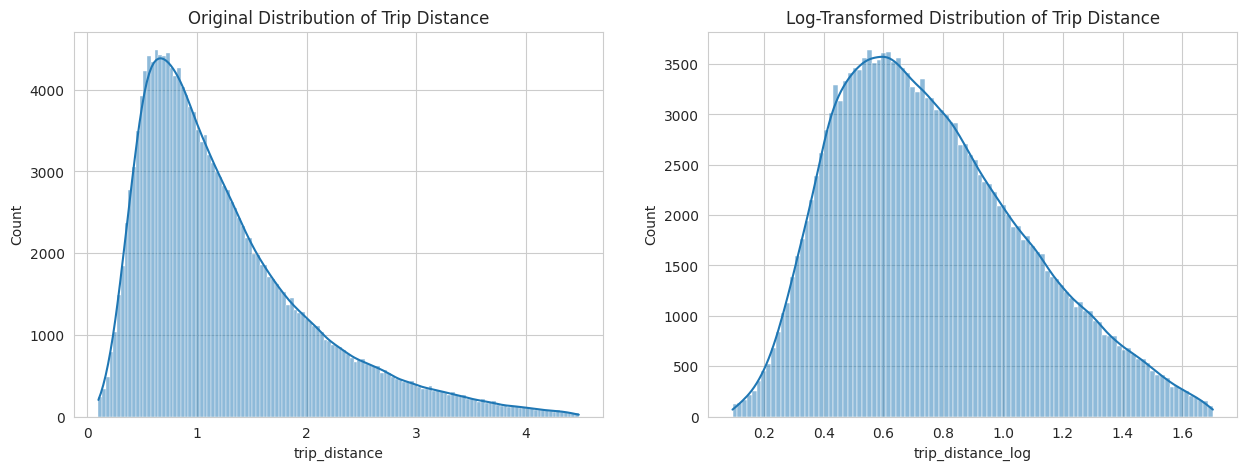

In [17]:
skewness = df[continuous_cols].skew()
print("Skewness of continuous features:")
print(skewness)

skewed_cols = ['trip_distance', 'trip_duration', 'fare_amount']


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['trip_distance'], kde=True, ax=axes[0])
axes[0].set_title('Original Distribution of Trip Distance')

#  log transformation
df['trip_distance_log'] = np.log1p(df['trip_distance'])

sns.histplot(df['trip_distance_log'], kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Distribution of Trip Distance')
plt.show()

df['trip_duration_log'] = np.log1p(df['trip_duration'])

**Feature Selection**

Correlation Analysis

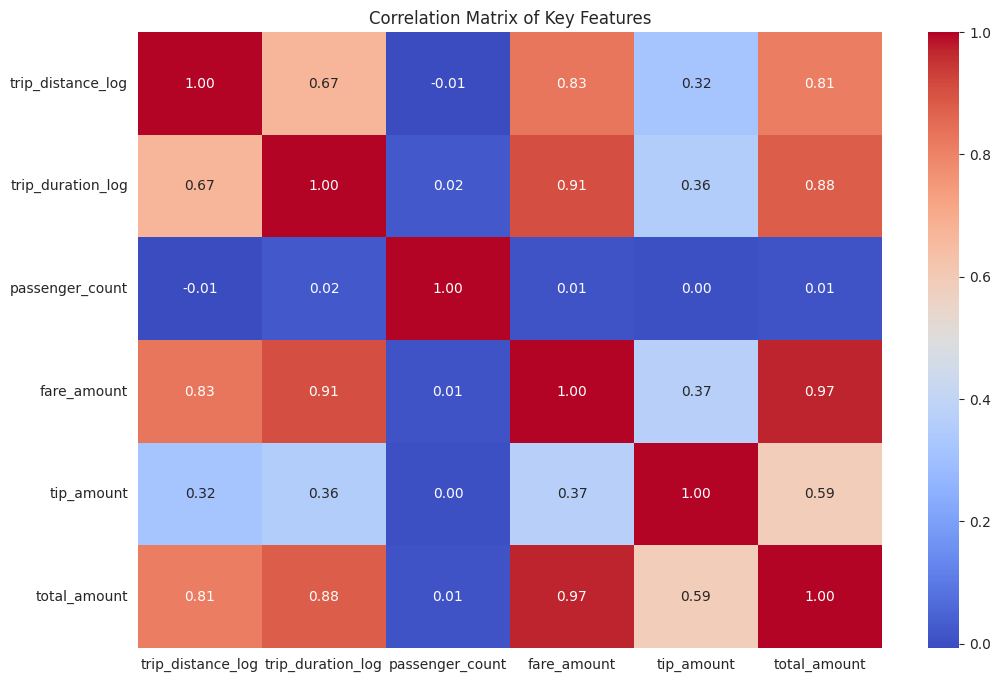

Based on correlation, 'fare_amount', 'tip_amount', etc., will be dropped to prevent data leakage.
The high correlation between trip distance and duration suggests one might be redundant.


In [18]:
plt.figure(figsize=(12, 8))
features_to_correlate = ['trip_distance_log', 'trip_duration_log', 'passenger_count', 'fare_amount', 'tip_amount', 'total_amount']
corr_matrix = df[features_to_correlate].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix of Key Features")
plt.show()

print("Based on correlation, 'fare_amount', 'tip_amount', etc., will be dropped to prevent data leakage.")
print("The high correlation between trip distance and duration suggests one might be redundant.")

In [20]:
initial_features = [
    'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'RatecodeID', 'payment_type',
    'pickup_hour', 'pickup_day_of_week', 'is_weekend', 'is_night',
    'trip_distance_log', 'trip_duration_log',

    'fare_amount', 'tip_amount', 'tolls_amount', 'mta_tax', 'improvement_surcharge'
]


leakage_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'mta_tax', 'improvement_surcharge']
final_features = [col for col in initial_features if col in df.columns and col not in leakage_cols]

print("--- Final list of features for the model ---")
print(final_features)

X = df[final_features]
y = df['total_amount']

print("\nShape of our final feature matrix (X):", X.shape)
print("Shape of our final target vector (y):", y.shape)

--- Final list of features for the model ---
['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'RatecodeID', 'payment_type', 'pickup_hour', 'pickup_day_of_week', 'is_weekend', 'is_night', 'trip_distance_log', 'trip_duration_log']

Shape of our final feature matrix (X): (174852, 13)
Shape of our final target vector (y): (174852,)


Chi-Square Test / ANOVA F-test

In [21]:
from sklearn.feature_selection import f_regression

categorical_features_for_selection = ['RatecodeID', 'payment_type', 'pickup_day_of_week', 'is_weekend', 'is_night']
X_cat = df[categorical_features_for_selection]
y_target = df['total_amount']

# The f_regression function returns F-statistics and p-values
f_scores, p_values = f_regression(X_cat, y_target)

# Create a DataFrame to view the results
anova_results = pd.DataFrame({'Feature': categorical_features_for_selection, 'F-Score': f_scores, 'P-Value': p_values})
anova_results = anova_results.sort_values(by='P-Value')

print("--- ANOVA F-test Results (Categorical Feature vs. Target) ---")
display(anova_results)

--- ANOVA F-test Results (Categorical Feature vs. Target) ---


,Feature,F-Score,P-Value
1,payment_type,12040.042209,0.000000e+00
4,is_night,234.276820,7.533852e-53
2,pickup_day_of_week,214.343854,1.655677e-48
0,RatecodeID,2.807479,9.382753e-02
3,is_weekend,0.000000,1.000000e+00


Feature Selection using RandomForestRegressor

Fitting model for feature importance...


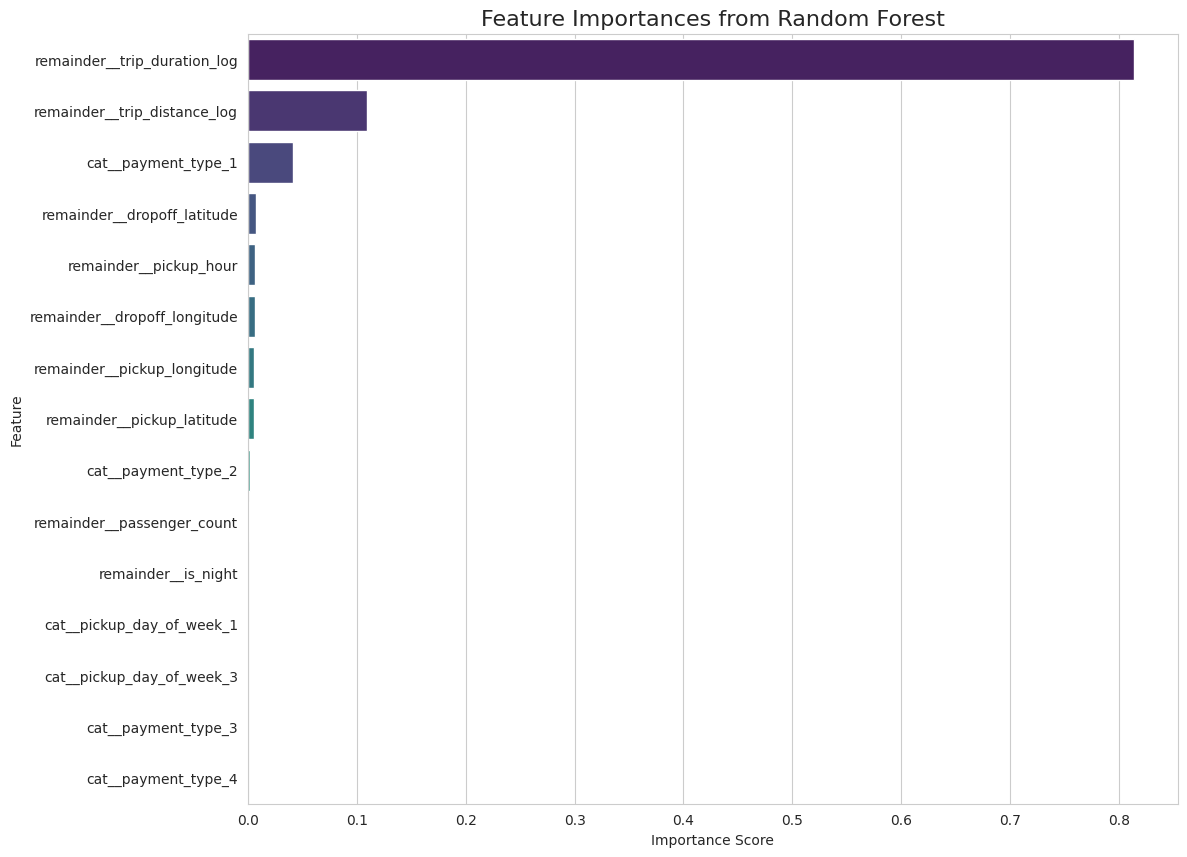


--- Top 10 Most Important Features ---


,Feature,Importance
14,remainder__trip_duration_log,0.813412
13,remainder__trip_distance_log,0.109539
0,cat__payment_type_1,0.041509
10,remainder__dropoff_latitude,0.007097
11,remainder__pickup_hour,0.006756
9,remainder__dropoff_longitude,0.006437
7,remainder__pickup_longitude,0.005879
8,remainder__pickup_latitude,0.005596
1,cat__payment_type_2,0.001734
6,remainder__passenger_count,0.001037


In [22]:
final_features = [
    'passenger_count',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'payment_type',
    'pickup_hour',
    'pickup_day_of_week',
    'is_night',
    'trip_distance_log',
    'trip_duration_log'
]

final_features = [f for f in final_features if f in df.columns]


X = df[final_features]
y = df['total_amount']

# Categorical features that need encoding
categorical_features = ['payment_type', 'pickup_day_of_week']

# ColumnTransformer to One-Hot Encode the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# the pipeline here basically automated the process of encoding the categorical features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
print("Fitting model for feature importance...")
pipeline.fit(X, y)

#  feature importances
importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Ploting the top features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# top 10 most important features
print("\n--- Top 10 Most Important Features ---")
display(importance_df.head(10))

Model Training and evaluation


Training Linear Regression...

Training Ridge...

Training Lasso...

Training Random Forest...

Training XGBoost...


--- FULL MODEL PERFORMANCE COMPARISON ---


,Train R²,Test R²,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE
XGBoost,0.973583,0.967824,0.489630,0.592828,0.699736,0.769954,0.476802,0.516918
Random Forest,0.994772,0.963926,0.096898,0.664655,0.311284,0.815264,0.202317,0.542127
Ridge,0.900434,0.901064,1.845394,1.822856,1.358453,1.350132,1.029028,1.027253
Linear Regression,0.900435,0.901061,1.845361,1.822903,1.358441,1.350149,1.028993,1.027218
Lasso,0.589690,0.590698,7.604808,7.541210,2.757682,2.746126,2.170319,2.160293



--- Detailed Analysis for Best Model: XGBoost ---


,Original_Fare,Predicted_Fare,Error
0,17.29,15.268826,2.021174
1,5.75,6.251436,-0.501436
2,17.25,15.426185,1.823815
3,10.30,9.883981,0.416019
4,8.30,8.465127,-0.165127
5,12.35,12.477801,-0.127801
6,14.76,14.225163,0.534837
7,13.56,13.352816,0.207184
8,5.76,5.699622,0.060378
9,11.76,11.742173,0.017827


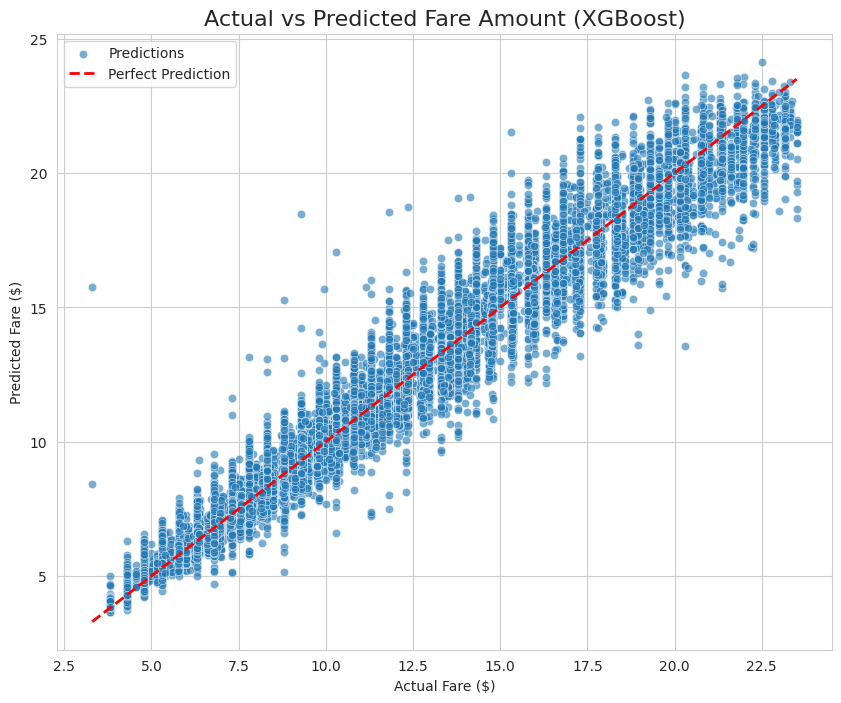

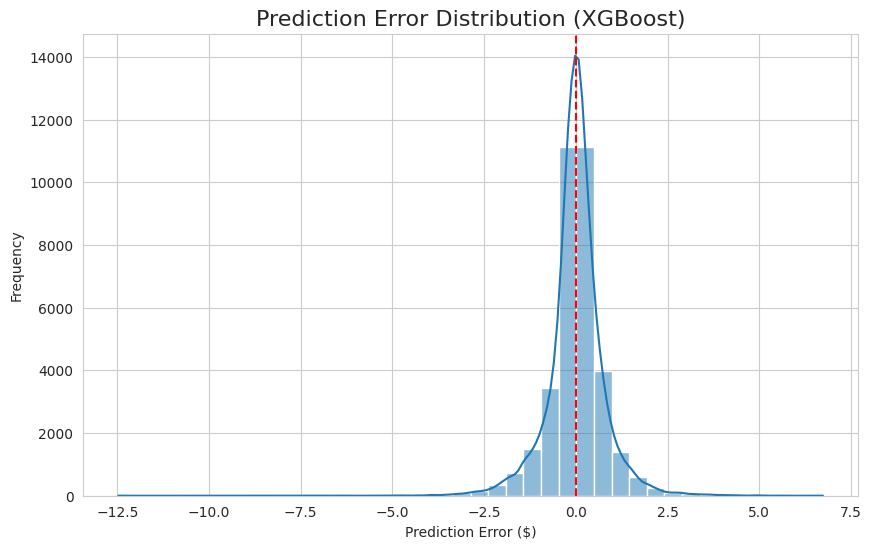

In [23]:
final_features = [
    'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'payment_type',
    'pickup_hour', 'pickup_day_of_week', 'is_night',
    'trip_distance_log', 'trip_duration_log'
]

X = df[final_features]
y = df['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['payment_type', 'pickup_day_of_week']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=1)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    return {
        'pipeline': pipeline,
        'metrics': {
            'Train R²': r2_score(y_train, y_pred_train),
            'Test R²': r2_score(y_test, y_pred_test),
            'Train MSE': mean_squared_error(y_train, y_pred_train),
            'Test MSE': mean_squared_error(y_test, y_pred_test),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'Train MAE': mean_absolute_error(y_train, y_pred_train),
            'Test MAE': mean_absolute_error(y_test, y_pred_test)
        }
    }

# Training and evaluating all models by calling the function
results = {}
for name, model in models.items():
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results[name] = result

# Collecting all the metrics for eval
metrics_df = pd.DataFrame({name: r['metrics'] for name, r in results.items()}).T
metrics_df = metrics_df.sort_values(by='Test R²', ascending=False)

print("\n\n--- FULL MODEL PERFORMANCE COMPARISON ---")
display(metrics_df)

# analyzing the best model out of these
best_model_name = metrics_df.index[0]
best_pipeline = results[best_model_name]['pipeline']
y_pred_best = best_pipeline.predict(X_test)

final_comparison_df = pd.DataFrame({
    'Original_Fare': y_test,
    'Predicted_Fare': y_pred_best,
    'Error': y_test - y_pred_best
}).reset_index(drop=True)

print(f"\n--- Detailed Analysis for Best Model: {best_model_name} ---")
display(final_comparison_df.head(15))

# Actual vs Predicted(plot)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=final_comparison_df, x='Original_Fare', y='Predicted_Fare', alpha=0.6, label='Predictions')
plt.plot([final_comparison_df['Original_Fare'].min(), final_comparison_df['Original_Fare'].max()],
         [final_comparison_df['Original_Fare'].min(), final_comparison_df['Original_Fare'].max()],
         color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.title(f'Actual vs Predicted Fare Amount ({best_model_name})', fontsize=16)
plt.xlabel('Actual Fare ($)')
plt.ylabel('Predicted Fare ($)')
plt.grid(True)
plt.legend()
plt.show()

# Error distribution(plot)
plt.figure(figsize=(10, 6))
sns.histplot(final_comparison_df['Error'], bins=40, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title(f'Prediction Error Distribution ({best_model_name})', fontsize=16)
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Save the model**

In [24]:
# Selecting the best model based on highest Test R²
best_model_name = metrics_df.index[0]
print(f"\n The best performing model is: {best_model_name}")
final_model_to_save = results[best_model_name]['pipeline']


with open('taxi_fare_predictor.pkl', 'wb') as f:
    pickle.dump(final_model_to_save, f)

print(f" Model '{best_model_name}' has been saved as 'taxi_fare_predictor.pkl'")


 The best performing model is: XGBoost
 Model 'XGBoost' has been saved as 'taxi_fare_predictor.pkl'


In [25]:
import sklearn
import xgboost
import pandas

print(f"Scikit-learn version used to SAVE the model: {sklearn.__version__}")
print(f"XGBoost version used to SAVE the model: {xgboost.__version__}")
print(f"Pandas version used to SAVE the model: {pandas.__version__}")

Scikit-learn version used to SAVE the model: 1.6.1
XGBoost version used to SAVE the model: 3.0.3
Pandas version used to SAVE the model: 2.2.2


Hyperparameter optimization has not been performed here because the models are almost perfect